<a href="https://colab.research.google.com/github/COGS118A/Group026-Sp22/blob/main/SVM_with_HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import the data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Data import
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2022-06-08 04:25:38--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  38.1MB/s    in 21s     

2022-06-08 04:26:00 (35.8 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2022-06-08 04:26:00--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  13.5MB/s    in 1.5s    

2022-06-08 04:26:02 (13.5 MB/s) - ‘annotat

In [3]:
#!tar -xvf annotation.tar

In [4]:
!mv annotation.tar '/content/gdrive/MyDrive/cogs118a'
!mv images.tar '/content/gdrive/MyDrive/cogs118a'

In [5]:
!cd '/content/gdrive/MyDrive/cogs118a/'

In [6]:
import os
os.chdir('/content/gdrive/MyDrive/cogs118a/')

In [7]:
#!tar -xvf images.tar

In [8]:
# import tarfile
# import csv
# import io

# Images= tarfile.open('images.tar',"w")

#Preprocess the data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import cv2
import os
from pathlib import Path
from tqdm import tqdm


In [10]:
directory = str(Path.cwd())

all_img_dir = [i for i in os.listdir(directory+'/Images') if 'n0' in i]
Name = []
for file in all_img_dir: 
    name = file.split('-')[-1]
    Name += [name]

In [11]:
def search_boundary(bd_path):
    with open(bd_path, 'r') as f:
        content = f.read()
        bds = []
        
        axes = ['xmin', 'xmax', 'ymin', 'ymax']
        for ax in axes:
            start = content.find('<'+ax+'>') +6
            end = content.find('</'+ax+'>')    
            
            bd = int(content[start:end])
            bds.append(bd) 

        
    return bds[0], bds[1], bds[2], bds[3]

In [12]:
def target_locator(img, xmin, xmax, ymin, ymax):
    if len(img.shape) == 3:
        image = img[ymin:ymax, xmin:xmax, :]
    else:
        image = img[ymin:ymax, xmin:xmax]
        
    return image

In [13]:
def load_image(N=len(Name), dsize=(128, 128)):
    train_data = [] #np.array([])
    test_data = [] #np.array([])
    train_label = [] #np.array([]) 
    test_label = [] #np.array([])

    for i in tqdm(range(N)): #len(Name)
        
        img_dir = os.path.join(directory+'/Images', all_img_dir[i])
        bd_dir = os.path.join(directory+'/Annotation', all_img_dir[i])
        
        n = len(os.listdir(img_dir))
        t = 0
        
        for im in os.listdir(img_dir):
            
            img_path = os.path.join(img_dir+'/', im)
            bd_path = os.path.join(bd_dir+'/', im[:-4])
            
            # Default is to read img in RGB scale
            img = np.flip(cv2.imread(img_path), #if grayscale: cv2.IMREAD_GRAYSCALE
                            axis=-1) 
            
            xmin, xmax, ymin, ymax = search_boundary(bd_path)
            image = target_locator(img, xmin, xmax, ymin, ymax)
    
            # skip faulty images
            if not np.any(image):
                t+=1
                continue
            
            image = cv2.resize(image, dsize=dsize)            
            image = image/255.0
            
            if t <= np.floor(n*0.8):
                train_data.append(image)
                train_label.append(Name[i])          
            else:
                test_data.append(image)
                test_label.append(Name[i])
        
            t+=1
    
    return train_data, test_data, train_label, test_label

In [14]:
n_class = 10
# rescale the data to 64*128 size
train_data, test_data, train_label, test_label = load_image(N=n_class, dsize=(64,128))

100%|██████████| 10/10 [07:50<00:00, 47.04s/it]


In [15]:
x_train = np.array(train_data)
x_test = np.array(test_data)

train_label = np.array(train_label)
test_label = np.array(test_label)

X_train = x_train.flatten().reshape(x_train.shape[0], -1)
X_test = x_test.flatten().reshape(x_test.shape[0], -1)

train_df = pd.DataFrame(X_train)
train_df['label'] = train_label

test_df = pd.DataFrame(X_test)
test_df['label'] = test_label

In [16]:
from skimage.feature import hog
from skimage import data, exposure

#Use HOG as kernel for SVM modeling

In [17]:
X_train = train_df.iloc[:,:-1].values
y_train = train_df['label'].values

X_test = test_df.iloc[:,:-1].values
y_test = test_df['label'].values

In [18]:
# transfer images to HOG form
train_images = []
train_features = []
test_images = []
test_features = []

for image in train_data:
  fd1, hog_image1 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2', visualize=True, 
                      multichannel=True)
  train_images.append(hog_image1)
  train_features.append(fd1)

for image in test_data:
  fd2, hog_image2 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2', visualize=True, 
                      multichannel=True)
  test_images.append(hog_image2)
  test_features.append(fd2)

Text(0.5, 1.0, 'HOG image')

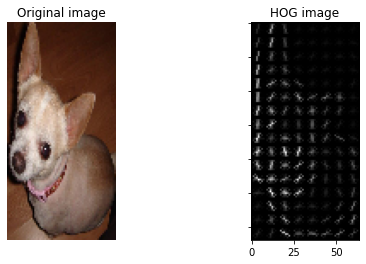

In [19]:
# Visualize one of the HOG images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(train_data[6], cmap=plt.cm.gray)
ax1.set_title('Original image')
ax2.imshow(train_images[6], cmap=plt.cm.gray)
ax2.set_title('HOG image')

In [20]:
# change the format of label for svm
train_label = np.array([Name.index(label) for label in train_label])
test_label = np.array([Name.index(label) for label in test_label])

train_labels =  np.array(train_label).reshape(len(train_label),1)
test_labels = np.array(test_label).reshape(len(test_label), 1)

In [21]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [38]:
# fit in the svm classifier to the images
clf = svm.SVC(C=10, kernel='rbf')
train_features = np.array(train_features)
train_frame = np.hstack((train_features,train_labels))
np.random.shuffle(train_frame)
test_festures = np.array(test_features)
test_frame = np.hstack((test_features,test_labels))

In [39]:
clf.fit(train_features, train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=10)

In [40]:
y_pred = clf.predict(test_features)

In [41]:
print("Accuracy: "+str(accuracy_score(test_labels, y_pred)))
print('\n')
print(classification_report(test_labels, y_pred))

Accuracy: 0.3726027397260274


              precision    recall  f1-score   support

           0       0.39      0.50      0.44        30
           1       0.37      0.58      0.45        50
           2       0.20      0.07      0.10        29
           3       0.38      0.36      0.37        42
           4       0.67      0.70      0.69        47
           5       0.15      0.21      0.17        34
           6       0.19      0.24      0.21        38
           7       0.46      0.35      0.40        34
           8       0.50      0.29      0.37        31
           9       0.45      0.17      0.24        30

    accuracy                           0.37       365
   macro avg       0.38      0.35      0.34       365
weighted avg       0.39      0.37      0.36       365

